# Analyzing online Blood Bowl matches using Python: API scraping, pandas and plotnine

When I was a teenager, back in 1994, I bought the Blood Bowl strategy boardgame. Its like chess, but instead of two medieval kingdoms fighting, the game is about fantasy football, say Tolkien meets rugby. Already back then, the game appealed to me because it combined the Warhammer playing pieces I liked so much (e.g. models of Orcs, Elves, Dwarves etc) with a game that had simple rules (compared to the main wargaming systems at the time, Warhammer Fantasy Battle, and Warhammer 40K), but resulted in complex gameplay. Blood bowl requires a lot of skill to play well, with complex strategic decision making in the face of uncertainty (heavy dice rolling involved). Then, after painting half of the figures, I moved on to new exciting things. But throughout the years, this was the only game I kept moving to new places etc.
To my surprise, when I regained interest a few years ago, an international gaming community had formed around the game, with a players' association, the NAF, with thousands of members, a World championship every two years, and with new editions and models being released on a regular basis.

So last year, I finally decided to pick it up again, painted the remaining figures (see photo below for the end result) and started my search for actual opponents to play against. I found a local community in a city nearby, and I am having a great time learning the strategic finesses of the all the teams, painting new miniatures, and looking forward to my first tabletop tournament, to be held in a few months if the dreaded Nurgle rot (aka Corona) allows it.

Of course, you want to see a photo of my painted team right? (It appears i am not the only one who has this urge, there are special Reddit and Facebook groups where you can showcase your painted Blood Bowl team).

Now, Another amazing thing happened while I was away: Blood Bowl went online, with people playing games using a (free!) client-server system called FUMBBL, that came into existence at around 2003. As with all sports (and yes, Blood Bowl is a sport, like Chess and Go), statistics are not far away. The website (https://fumbbl.com) is one big pile of data. From coach pages, with their teams, to team rosters, with players, and match histories. It's all there. And what's more: the site creator Christer Kaivo-oja, from Sweden, has made an API that allows us to easily fetch data. The full documentation of the API can be found at (https://fumbbl.com/apidoc/). 

The goal of this blog post is to use Python API scraping to fetch the data, and to use the pandas and plotnine packages to analyse and visualise the data.

We do three analyses:

* Which races are most popular?
* Ploting the number of games per week over time for each division
* Plotting the average win rate for each team race
* Comparing that win rate between the old and new rules to see what changed

Along the way we discover what it is possible. A big limitation of the API is that it shows the current status of the teams and leagues.
This means for example, that for matches played in the past, team value is no longer available. Also, leagues that change their rules, for example the NAF switched to the new ruleset (including Khorne and Slann) in september 2021, but matches played earlier under this ruleset were played  using BB2016 rules.

PM Questions we answer (races, ruleset) and why

# Behold, the power of Requests / Using Python to fetch FUMBBL data

We use the [Python **Requests** library](https://docs.python-requests.org/en/latest/) to make the API call over HTTPS and obtain the response from the FUMBLL server. The response is in the JSON format, a [light-weight data-interchange format](https://www.json.org/json-en.html) which is both easy to read and write for humans, and easy to parse and generate by computers. So this makes it a natural choice for an API.

Here is an example of what is available at the coach level (in Blood Bowl, people playing the game are called *coaches*, since the playing pieces are already called the *players*). A complete overview of what available in the FUMBBL API is here []()


In [33]:
import requests
import random
import pandas as pd
import time

response = requests.get("https://fumbbl.com/api/coach/teams/gsverhoeven")
# display the complete JSON object {}
response.json()

{'id': 255851,
 'name': 'gsverhoeven',
 'teams': [{'id': 1003452,
   'coachId': 255851,
   'name': 'Hillywood Hellraisers',
   'rosterId': 50,
   'race': 'Human',
   'teamValue': 1090000,
   'canLfg': 'Yes',
   'isLfg': 'Yes',
   'games': '3',
   'divisionId': 1,
   'division': 'Ranked',
   'leagueId': 0,
   'league': None,
   'status': 'Retired',
   'raceLogos': [{'size': 32, 'logo': 486290},
    {'size': 48, 'logo': 486291},
    {'size': 64, 'logo': 486292},
    {'size': 96, 'logo': 486293},
    {'size': 128, 'logo': 486294},
    {'size': 192, 'logo': 486295}]},
  {'id': 1035833,
   'coachId': 255851,
   'name': 'Pharaoh Munchers',
   'rosterId': 51,
   'race': 'Tomb Kings',
   'teamValue': 960000,
   'canLfg': 'Yes',
   'isLfg': 'No',
   'games': '0',
   'divisionId': 1,
   'division': 'Ranked',
   'leagueId': 0,
   'league': None,
   'status': 'Active',
   'raceLogos': [{'size': 32, 'logo': 486296},
    {'size': 48, 'logo': 486297},
    {'size': 64, 'logo': 486298},
    {'size': 96

# Parsing JSON data

Let's have a close look at the JSON data structure here.
We have a list of key-value pairs. 
Some keys contain simple values, such as `name`, 

In [34]:
response.json()['name']

'gsverhoeven'

but some return as value a new list of key-value pairs, such as `teams`.
Actually this is a list of lists of key-value pairs, since we have a separate list for each team.
Even the list of a single team contains new structure, for example under the key `raceLogos`.

In [35]:
response.json()['teams'][2]['raceLogos']

[{'size': 32, 'logo': 486290},
 {'size': 48, 'logo': 486291},
 {'size': 64, 'logo': 486292},
 {'size': 96, 'logo': 486293},
 {'size': 128, 'logo': 486294},
 {'size': 192, 'logo': 486295}]

In [36]:
response.json()['teams'][2]['name']

'Blackbox Bastards'

# Getting the data in a Pandas dataframe for analysis

Now we know how the data comes in, we need to think about how we want it.

Now what would be a logical data structure to analyse race strength?

The most straightforward level to analyze race strength is to look at **match outcomes**.
Furthermore, we expect race strength to change over time, as new strategies are discovered by the players, or new rules get introduced. So the time dimension is important as well.

For now, we go with a flat data frame with **rows for each match**, and columns for the various variables associated with each match.
These would include:

* Coach ids
* Races
* Team ids
* Date of the match
* Outcome (Touchdowns of both teams)

With this basic structure, we can add as many match related variables in the future, keeping the basic structure (each row is a match) unchanged.

So lets get the match data!



# Step 1: Getting the match data

So we are mostly intested in the current ruleset, this is `BB2020`. This ruleset became available last month, and some 5000 games have been played since.
We also want to compare with the previous ruleset, where we have much more data available. How far do we go back? 
Lets start with matches played during the last year. So starting from september 1st, 2020, up to oktober 1st, 2021. 
This way, we have roughly 12 months of `BB2016` ruleset matches, and one month of `BB2020` matches.

Easiest way to fetch them appears to just loop over `match_id`. The most recent match was 4.334.456, and since rougly 100.000 matches are played each year, we can fiddle about and we find match 4.226.550 played on september 1st, 2020.  So that means we need to collect some 110K matches. 
We do not want to overload the server, so let's make two API requests per second. To collect 110K matches, we will need 110000*0.5/3600 = 15 hours.
We can manage this by two nightly runs of 8 hours.

In [37]:
# estimated hours fetching data
110000*0.5/3600

15.277777777777779

In [38]:
import time
import numpy as np


df_matches_final = pd.DataFrame(columns=['match_id', 'match_date', 'match_time',  
    'team1_id', 'team1_coach_id', 'team1_roster_id', 'team1_race_name', 'team1_value',
    'team2_id', 'team2_coach_id', 'team2_roster_id', 'team2_race_name', 'team2_value',
    'team1_score', 'team2_score'])

target = 'data/df_matches_' + time.strftime("%Y%m%d_%H%M%S") + '.h5'
print(target)

end_match = 4339204	
begin_match = 4216257 
n_matches = end_match - begin_match
full_run = 0
print(n_matches)

if(full_run):
    for i in range(n_matches):
        api_string = "https://fumbbl.com/api/match/get/" + str(end_match - i)
        # wait 0.5 s on average between each API call
        wait_time = (random.uniform(0.5, 1) + 0.25)/3
        time.sleep(wait_time)
        match = requests.get(api_string)
        match = match.json()
        if match: # fix for matches that do not exist
            match_id = match['id']
            match_date = match['date']
            match_time = match['time']
            team1_id = match['team1']['id']
            team2_id = match['team2']['id']
            team1_score = match['team1']['score']
            team2_score = match['team2']['score']  
            team1_roster_id = match['team1']['roster']['id']
            team2_roster_id = match['team2']['roster']['id']            
            team1_coach_id = match['team1']['coach']['id']
            team2_coach_id = match['team2']['coach']['id']
            team1_race_name = match['team1']['roster']['name'] 
            team2_race_name = match['team2']['roster']['name'] 
            team1_value = match['team1']['teamValue']
            team2_value = match['team2']['teamValue']
            #print(match_id)     
            df_matches_final.loc[i] = [match_id, match_date, match_time, 
                team1_id, team1_coach_id, team1_roster_id, team1_race_name, team1_value,
                team2_id, team2_coach_id, team2_roster_id, team2_race_name, team2_value,
                team1_score, team2_score]
        else:
            # empty data for this match, create empty row
            match_id = int(end_match - i)
            df_matches_final.loc[i] = [np.NaN, np.NaN, np.NaN, 
            np.NaN,np.NaN,np.NaN,np.NaN,
            np.NaN,np.NaN,np.NaN,np.NaN,
            np.NaN,np.NaN, np.NaN, np.NaN] # try np.repeat([np.NaN], 13, axis=0) next time
            df_matches_final.loc[i]['match_id'] = int(match_id)
        if i % 100 == 0: 
            # write tmp data as hdf5 file
            print(i, end='')
            print(".", end='')
            df_matches_final.to_hdf(target, key='df_matches_final', mode='w')

    # write data as hdf5 file
    df_matches_final.to_hdf(target, key='df_matches_final', mode='w')
else:
    # read from hdf5 file
    #df_matches_final = pd.read_hdf('data/df_matches_20211102_083311.h5')
    df_matches_final = pd.read_hdf('data/df_matches_20211106_205843.h5')
#
df_matches_final.shape

data/df_matches_20211109_094352.h5
122947


(122947, 15)

In [39]:
# convert object dtype columns to proper pandas dtypes datetime and numeric
df_matches_final['match_date'] = pd.to_datetime(df_matches_final.match_date) 
df_matches_final['match_id'] = pd.to_numeric(df_matches_final.match_id) 
df_matches_final['team1_id'] = pd.to_numeric(df_matches_final.team1_id) 
df_matches_final['team1_coach_id'] = pd.to_numeric(df_matches_final.team1_coach_id) 
df_matches_final['team1_roster_id'] = pd.to_numeric(df_matches_final.team1_roster_id) 
df_matches_final['team2_id'] = pd.to_numeric(df_matches_final.team2_id) 
df_matches_final['team2_coach_id'] = pd.to_numeric(df_matches_final.team2_coach_id) 
df_matches_final['team2_roster_id'] = pd.to_numeric(df_matches_final.team2_roster_id) 
df_matches_final['team1_score'] = pd.to_numeric(df_matches_final.team1_score) 
df_matches_final['team2_score'] = pd.to_numeric(df_matches_final.team2_score) 

In [40]:
df_matches_final.dtypes


match_id                    int64
match_date         datetime64[ns]
match_time                 object
team1_id                  float64
team1_coach_id            float64
team1_roster_id           float64
team1_race_name            object
team1_value                object
team2_id                  float64
team2_coach_id            float64
team2_roster_id           float64
team2_race_name            object
team2_value                object
team1_score               float64
team2_score               float64
dtype: object

In [41]:
# 123K matches
df_matches_final

,match_id,match_date,match_time,team1_id,team1_coach_id,team1_roster_id,team1_race_name,team1_value,team2_id,team2_coach_id,team2_roster_id,team2_race_name,team2_value,team1_score,team2_score
0,4339204,2021-10-28,18:04:17,1042561.0,253662.0,5142.0,Chaos Dwarf,1100k,1051752.0,251841.0,4972.0,Old World Alliance,1100k,0.0,1.0
1,4339203,2021-10-28,17:49:15,1047262.0,231486.0,4963.0,Halfling,720k,1048037.0,228505.0,4974.0,Orc,1100k,2.0,1.0
2,4339202,2021-10-28,17:43:25,1045283.0,252586.0,4975.0,Shambling Undead,1080k,1052026.0,255647.0,4959.0,Dark Elf,1010k,2.0,0.0
3,4339201,2021-10-28,17:42:16,1003067.0,255343.0,55.0,Nurgle,2330k,1002983.0,255809.0,57.0,Orc,2370k,2.0,1.0
4,4339200,2021-10-28,17:40:09,1047603.0,67411.0,4969.0,Necromantic Horror,1170k,1050787.0,254711.0,4956.0,Black Orc,1200k,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122942,4216262,2020-08-01,22:53:07,995283.0,235272.0,364.0,Daemons of Nurgle,1000k,995327.0,238300.0,395.0,Skink,980k,0.0,2.0
122943,4216261,2020-08-01,22:51:25,990875.0,254533.0,54.0,Norse,1230k,994045.0,134383.0,53.0,Necromantic Horror,1230k,0.0,3.0
122944,4216260,2020-08-01,22:50:14,983323.0,245537.0,41.0,Amazon,1390k,988905.0,250129.0,55.0,Nurgle,1680k,0.0,1.0
122945,4216259,2020-08-01,22:50:05,989053.0,254630.0,47.0,Goblin,940k,967266.0,250588.0,50.0,Human,920k,0.0,2.0


# First analysis: Orcs are most popular!

Which races are the most popular on FUMBLL in the last year?
For this, we need only to count which races were chosen how many times.

However, since each match contains two teams, we need to create a new dataframe `df_races`, double in size, that contains for each row the `match_id` and `team_race` of one of the two teams.

In [42]:
team1_races = df_matches_final[['match_id', 'team1_race_name']]
team2_races = df_matches_final[['match_id', 'team2_race_name']]

# make column names equal
team1_races.columns = team2_races.columns = ['match_id', 'race_name']

# row bind the two dataframes
df_races = pd.concat([team1_races, team2_races])

# aggregate by race_name
res = (df_races
        .groupby(['race_name'])
        .size()
        .reset_index(name='n_games')
)

# select most popular races for filtering
top_races = res.loc[(res.n_games > 1000)]['race_name']



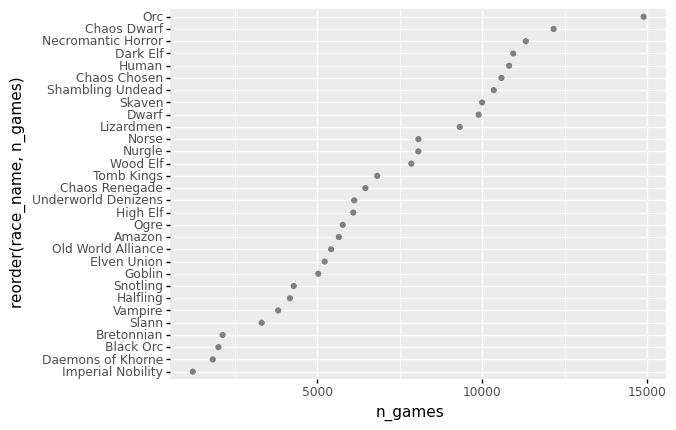

<ggplot: (8759710608497)>

In [43]:
import plotnine as p9

(p9.ggplot(data = res.loc[res['race_name'].isin(top_races)], mapping = p9.aes(x = 'reorder(race_name, n_games)', y = 'n_games'))
    + p9.geom_point(colour = 'gray') 
    + p9.coord_flip())

So the orcs are most popular! 

# dataprep: df_wins prepare for raw win rates by race

If we want to calculate a win rate for each race, we need to decide what to do with draws.
I've never given the matter much thought, but it turns out other people have!
For example, in football, there is a popular weighting scheme where wins are given 3 points, draws 1 point and losses 0 points.
This is called [three points for a win](https://en.wikipedia.org/wiki/Three_points_for_a_win) . 
In Blood bowl leagues and tournaments, my impression is that this rule is used often as well.

Mike Davies from the NAF calculates win rate by weighting each win as 1 point, and each draw as 0.5 points (For example, [here](https://public.tableau.com/app/profile/mike.sann0638.davies/viz/NAFGames_0/SuccessBB2020)). Let's do the same here!

This creates again a dataframe that is double in size, `df_wins` because each match generates two rows.

In [44]:
import numpy as np

# calculate match score difference
df_matches_final['team1_win'] = np.sign(df_matches_final['team1_score'] - df_matches_final['team2_score'])
df_matches_final['team2_win'] = np.sign(df_matches_final['team2_score'] - df_matches_final['team1_score'])

team1_wins = df_matches_final[['match_id', 'match_date', 'team1_id', 'team1_race_name', 'team1_value', 'team1_win']].copy()

team2_wins = df_matches_final[['match_id', 'match_date',  'team2_id', 'team2_race_name', 'team2_value', 'team2_win']].copy()


team1_wins.columns = team2_wins.columns = ['match_id', 'match_date', 'team_id', 'race_name', 'team_value', 'wins']
#team2_wins['wins'] = -1 * team2_wins['wins']

df_wins = pd.concat([team1_wins, team2_wins])

df_wins.loc[df_wins['wins'] == 0, 'wins'] = 0.5
df_wins.loc[df_wins['wins'] == -1, 'wins'] = 0

# convert to float
df_wins['wins'] = df_wins['wins'].astype(float)

# convert team value 1100k to 1100 integer and and above / below median (= low / high TV)
df_wins['team_value'] = df_wins['team_value'].str.replace('k$', '')
df_wins['team_value'] = df_wins['team_value'].fillna(0).astype(np.int64)

df_wins['tv_quartile'] = pd.qcut(df_wins['team_value'], q=2)




In [45]:
df_wins.query('team_value < 800 & team_value > 0')#['team_value'].describe()

,match_id,match_date,team_id,race_name,team_value,wins,tv_quartile
1,4339203,2021-10-28,1047262.0,Halfling,720,1.0,"(-0.001, 1220.0]"
23,4339181,2021-10-28,1052013.0,Amazon,790,0.5,"(-0.001, 1220.0]"
45,4339159,2021-10-28,712875.0,Goblin,520,0.0,"(-0.001, 1220.0]"
214,4338990,2021-10-27,1043662.0,Halfling,720,0.5,"(-0.001, 1220.0]"
333,4338871,2021-10-27,1044286.0,Snotling,720,0.0,"(-0.001, 1220.0]"
...,...,...,...,...,...,...,...
122580,4216624,2020-08-02,972030.0,[Φ] Weijin,400,0.0,"(-0.001, 1220.0]"
122581,4216623,2020-08-02,994152.0,Halfling,700,0.5,"(-0.001, 1220.0]"
122610,4216594,2020-08-02,973444.0,[Φ] Gandharva,360,0.5,"(-0.001, 1220.0]"
122633,4216571,2020-08-02,994272.0,Giant,630,1.0,"(-0.001, 1220.0]"


# Tidyverse-like data analysis with Pandas and plotnine

Doing most of my day to day analysis in `R`, i am (by now) used to the tidyverse filosophy of breaking things apart in small steps, with each step on a separate line, and in order of execution. Luckily, the `Pandas` data analysis library allows us to do something similar, here it is called `method chaining`.
The idea is that a Pandas object has methods for all the small operations we want to perform, and the python language that allows chaining these methods together.

Here we demonstrate this by calculating average win percentage by race, and calling this result `perc_win`.

**We still ignore ruleset and division because we do not have it yet.**

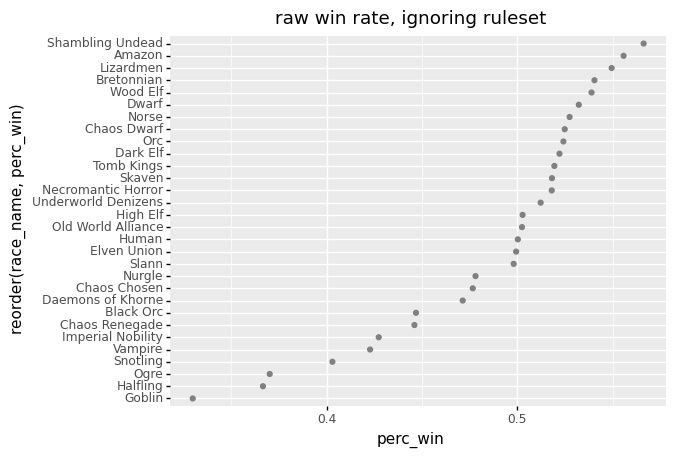

<ggplot: (8759726014696)>

In [46]:
import plotnine as p9

res = (df_wins
        .loc[df_wins['race_name'].isin(top_races.array)]
        .groupby('race_name')['wins']        
        .mean()
        .reset_index(name='perc_win'))


(p9.ggplot(data = res, mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win'))
    + p9.geom_point(colour = 'gray') 
    + p9.coord_flip()
    + p9.ggtitle("raw win rate, ignoring ruleset"))

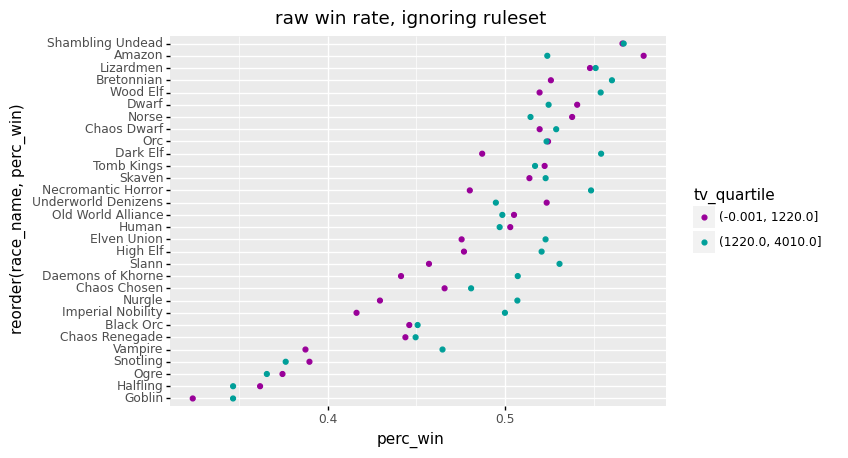

<ggplot: (-9223363277144940137)>

In [47]:
res = (df_wins
        .loc[df_wins['race_name'].isin(top_races.array)]
        .query('team_value > 800 & team_value < 2500')
        .groupby(['race_name', 'tv_quartile'])['wins']        
        .mean()
        .reset_index(name='perc_win'))


(p9.ggplot(data = res, mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', color = 'tv_quartile'))
    + p9.geom_point() 
    + p9.coord_flip()
    + p9.scale_color_manual(values=["#990099", "#009F99"])
    + p9.ggtitle("raw win rate, ignoring ruleset"))

# Step 2: Fetch team level data (division, ruleset, roster, games_played) for all the teams in our matches dataset

Let grab for all teams in `df_matches` the team **race** and **ruleset**.
The ruleset is important, because races can get **nerfed** (made weaker) or **buffed** (made stronger) when new versions of the ruleset are released.
These changes are common in any gaming community, in an attempt to achieve more balance in the game.

The division is also important. 

530 min for 44K teams. This uses Python sets (minus operator gives elements of set that are different)

In [48]:
df_teams = pd.DataFrame(columns=['team_id', 'division_id', 'division_name',  'league' ,
    'ruleset', 'roster_id', 'race_name',  'games_played'])

team_ids = list(df_matches_final['team1_id'].dropna()) + list(df_matches_final['team2_id'].dropna())


# get unique values (nog steeds floats, grrr)
team_ids = list(set(team_ids))

target = 'data/df_teams_' + time.strftime("%Y%m%d_%H%M%S") + '.h5'
print(target)

fullrun = 0

if fullrun:
    print('fetching team data for ', len(team_ids), ' teams')
    for t in range(len(team_ids)):    
        api_string = "https://fumbbl.com/api/team/get/" + str(int(team_ids[t]))
        wait_time = (random.uniform(0.5, 1) + 0.25)/2 # avg time 0.5 s
        time.sleep(wait_time)
        team = requests.get(api_string)
        team = team.json()
        # grab fields
        team_id = team['id']
        division_id = team['divisionId']
        division_name = team['division']
        ruleset = team['ruleset']
        league = team['league']
        roster_id = team['roster']['id']
        race_name = team['roster']['name']
        games_played = team['record']['games']
        # add to dataframe
        df_teams.loc[t] = [team_id, division_id, division_name, league, ruleset, roster_id, race_name, games_played]
        if t % 100 == 0: 
            # write tmp data as hdf5 file
            print(t, end='')
            print(".", end='')
            df_teams.to_hdf(target, key='df_teams', mode='w')
    
    df_teams.to_hdf(target, key='df_teams', mode='w')
else:
    # read from hdf5 file
    df_teams = pd.read_hdf('data/df_teams_20211030_115137.h5')

#df_teams

data/df_teams_20211109_094358.h5


So how many teams do we have? We have data on 43K teams.

In [49]:
df_teams.shape


(43747, 8)

# FUMBBL divisions and rulesets

FUMBBL allows coaches to create their own rulesets to play their own leagues and tournaments with. For example, there is a so-called "Secret League" where coaches can play with "Ninja halflings", of with "Ethereal" spirits etc. 

Since we want the team strength for the official rulesets, we need to drop the other rulesets.
Also differences between divisions are potentially of importance.

Lets have look at the various divisions and leagues, which rulesets are used, and which races are played how often.
We only look at divisions and leagues with a sufficient volume of matches, or otherwise we do not have sufficient statistics for each race.
This gives us 33K teams of 43K, so roughly 75% of all teams created last year.



## Filter on most common rulesets

In [50]:
(df_teams
    .groupby(['ruleset',  'league', 'division_id', 'division_name'])
    .agg( n_teams = ('ruleset', 'count')
    )
    .query('n_teams > 1000')['n_teams']
    .sum()
)



32688


* Ruletset 4: BB2020 (correlated with Competitive division)
* Ruleset 1: BB2016 (correlated with Ranked division but also with Black box)
* Ruleset 6: League
* Ruleset 2228: NAF-BB2020
* Ruleset 303: United Open Rules (used by the Secret League, it allows teams like Ethereal)

# League analyse

There are a lot of small leagues being played on FUMBBL. Reasons to play in small local leagues vary.

There are a few larger leagues, that have nation wide scale. 

There are two leagues that are international and have sufficient scale to analyse separately.

This is the NAF tournaments (league 9298), and the Secret League (10263).

## NAF Tournaments: What is with ruleset 2228

They seem to be small scale, but consistent 6 week duration events? lets look up a few matches on FUMBBL.

match 4274272 is within a tournament called SteelBowl 2021 [EU]
The tournament has start /end dates 24 jan 2021. The match was at 29 jan.

The match was a league division game, the team played 6 games in jan/feb/march.
The League is called Online NAF tournaments.
ACtually this is a group 9298 that contains tournaments.
The group uses ruleset 2228.

# So final groupings

* Competitive BB2020
* Ranked BB2016
* Black box BB2016
* League ruleset 6 / league 0 (regular league)
* League ruleset 2228 / league 9298 (NAF tournaments)

Checked by christer: Does this mean that the API only serves the most recent version of a ruleset, and that rulesets can be changed without requiring a new ruleset id to be created? Correct

## Rulesets can be overwritten 

Ruleset 2228 appears to be BB2020 + slann + khorne, which the NAF prefers over the GW BB2020 ruleset.
From the roster ids, we can see that only from oktober 2021, the NAF switched to BB2020 teams.

In [51]:
common_rulesets = (df_teams
    .groupby(['ruleset', 'league', 'division_id', 'division_name'])
    .agg( n_teams = ('ruleset', 'count')
    )
    .query('n_teams > 100')
    .reset_index()
)['ruleset']

# Dataprep: Merging the match data with the team / ruleset data

For each match in the `df_wins` **DataFrame** we add the team-level information for `df_teams`.

In [52]:
df_wins = pd.merge(df_wins.drop('race_name', 1), df_teams, on='team_id', how='left')

df_wins['roster_name'] = df_wins['roster_id'].astype(str) + '_' + df_wins['race_name']

df_wins.query("match_id == 4339204")

,match_id,match_date,team_id,team_value,wins,tv_quartile,division_id,division_name,league,ruleset,roster_id,race_name,games_played,roster_name
0,4339204,2021-10-28,1.04256e+06,1100,0.0,"(-0.001, 1220.0]",2,Competitive,0,4,5142,Chaos Dwarf,6,5142_Chaos Dwarf
122947,4339204,2021-10-28,1.05175e+06,1100,1.0,"(-0.001, 1220.0]",2,Competitive,0,4,4972,Old World Alliance,7,4972_Old World Alliance


# Dataprep: Adding Week number to df_wins

drop week 44 of 2021 because it is incomplete? we could use it for the win rate?

In [53]:
df_wins['week_number'] = df_wins['match_date'].dt.isocalendar().week
#df_wins['week_number'] = df_wins['week_number'].astype('Int64')
df_wins['week_number'] = df_wins['week_number'].fillna(0).astype(np.int64)

df_wins
# cannot convert to np int64 becaues of missing values
# cannot convert to 'int64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.
df_wins['year'] = pd.DatetimeIndex(df_wins['match_date']).year

# fix week 53 weeks jan 2021
df_wins.loc[(df_wins['year'] == 2021) & (df_wins['week_number'] == 53), 'year'] = 2020

df_wins.dtypes


match_id                  int64
match_date       datetime64[ns]
team_id                  object
team_value                int64
wins                    float64
tv_quartile            category
division_id              object
division_name            object
league                   object
ruleset                  object
roster_id                object
race_name                object
games_played             object
roster_name              object
week_number               int64
year                    float64
dtype: object

# Dataprep: adding division name and ruleset_name groups for analysis

Should add this to the df_teams , then join this to the df_wins

In [54]:
# Splitting out a few particular leagues
df_wins.loc[(df_wins['league'] == 9298), 'division_name'] = 'NAF'
df_wins.loc[(df_wins['league'] == 0) & (df_wins['ruleset'] == 6), 'division_name'] = 'Regular_league'
df_wins.loc[(df_wins['league'] == 10263), 'division_name'] = 'Secret League'
df_wins.loc[(df_wins['league'] == 10455), 'division_name'] = 'CIBBL'

df_wins['ruleset_name'] = 'bb2016'
df_wins['ruleset_name'] = 'bb2016'
df_wins.loc[df_wins['division_name'] == 'Competitive', 'ruleset_name'] = 'bb2020'
df_wins.loc[df_wins['division_name'] == 'NAF', 'ruleset_name'] = 'mixed'


In [55]:
res = (df_wins
    .groupby(['week_number', 'year'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2

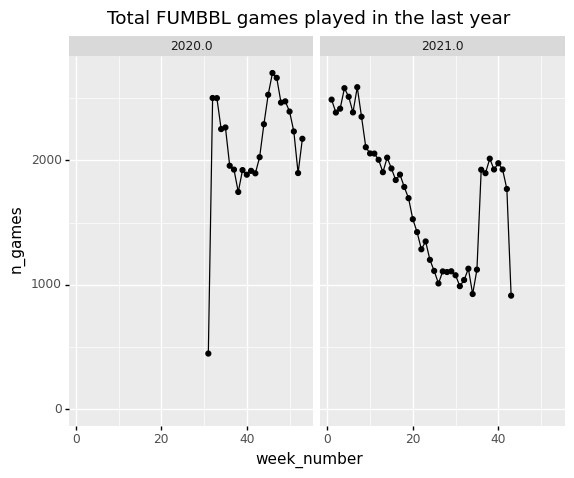

<ggplot: (8759706193654)>

In [56]:
(p9.ggplot(data = res, mapping = p9.aes(x = 'week_number', y = 'n_games'))
    + p9.geom_point() 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.facet_wrap('year')
    + p9.ggtitle("Total FUMBBL games played in the last year"))

    # yes we exactly reproduce the counts from FUMBBL 30 week plot

# Reproduce the FUMBBL 30-weeks plot

We can see that the new ruleset is a big succes, with the number of games played on FUMBBL almost doubled going from august to september 2021!

Starting in march 2020, online gaming activity saw a huge surge. Tabletop leagues switched to online etc. 
We can also see that the COVID-19 effect was declining in 2021, with game volume in july 2021 almost back at pre-corona levels.

As a check on our work, we compare with the plots that FUMBBL itself provides at https://fumbbl.com/p/stats


In [57]:
res = (df_wins
    .groupby(['division_name', 'week_number', 'year'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2


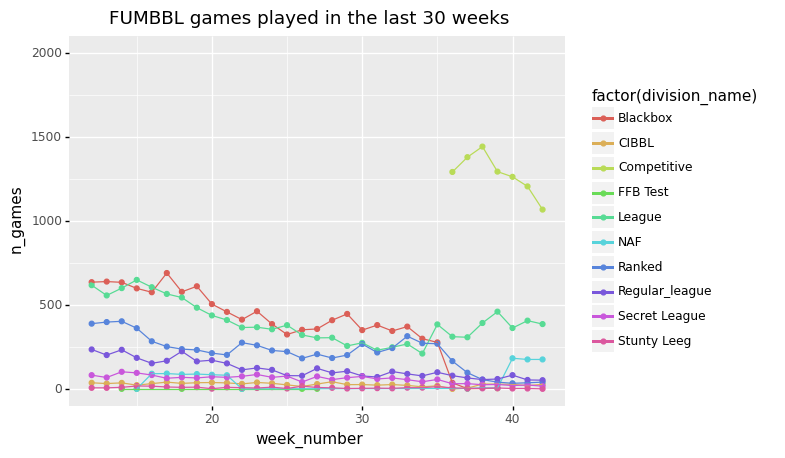

<ggplot: (8759706159308)>

In [58]:
(p9.ggplot(data = res.query('year > 2020 & week_number < 43 & week_number > 11'), mapping = p9.aes(x = 'week_number', y = 'n_games', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point() 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.ggtitle("FUMBBL games played in the last 30 weeks"))

    # yes we exactly reproduce the counts from FUMBBL 30 week plot

# Main analysis: win rate BB2016 vs BB2020

If we want two summary statistics instead of one, we need to use the `agg()` method.
Furthermore, if we want the variable we group over as a regular column in the DataFrame, we need to use `reset_index()`.
Now we have the data ready to make a nice plot.

We are going to do the comparison for the main divisions that use BB2016 and BB2020 rules.
The BB2016 rules are in three divisions: Blackbox, Ranked and regular league.

In [59]:
res = (df_wins
    .groupby(['division_name', 'ruleset', 'league'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2

main_divisions = res.query('n_games > 6000')['division_name']


In [70]:
res = (df_wins[df_wins['division_name'].isin(main_divisions)]
    #.query('team_value > 800 & team_value < 2500')
    .groupby(['race_name', 'ruleset_name', 'tv_quartile'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 0')
    .reset_index()) # this adds the group by variable (now index) as a column

#res.sort_values('n_games')

In [71]:
# weird: adding tv_quartile brings up n_games 0 in .agg
res

,race_name,ruleset_name,tv_quartile,perc_win,n_wins,n_games
0,Amazon,bb2016,"(-0.001, 1220.0]",0.580771,1039.0,1789
1,Amazon,bb2016,"(1220.0, 4010.0]",0.509145,946.5,1859
2,Amazon,bb2020,"(-0.001, 1220.0]",0.667059,283.5,425
3,Amazon,bb2020,"(1220.0, 4010.0]",0.613208,32.5,53
4,Black Orc,bb2020,"(-0.001, 1220.0]",0.446016,599.0,1343
...,...,...,...,...,...,...
107,Vampire,bb2020,"(1220.0, 4010.0]",0.392157,40.0,102
108,Wood Elf,bb2016,"(-0.001, 1220.0]",0.506268,1050.0,2074
109,Wood Elf,bb2016,"(1220.0, 4010.0]",0.541121,1737.0,3210
110,Wood Elf,bb2020,"(-0.001, 1220.0]",0.486264,177.0,364


# Adding credible intervals for the win rates

Comparing the win rates of BB2016 and BB2020 to koadah's dataset on http://fumbbldata.azurewebsites.net/stats.html , we find strong agreement.


In [72]:
import statsmodels.api as sm
# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )


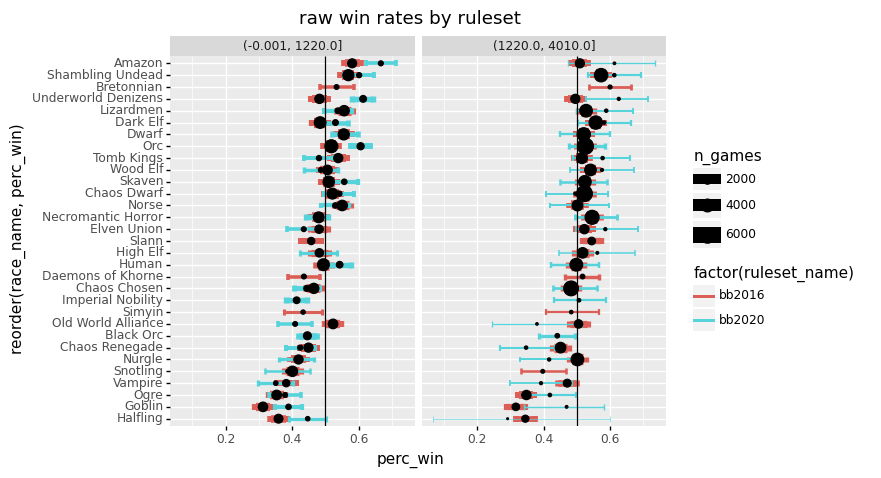

<ggplot: (-9223363277144001122)>

In [76]:

(p9.ggplot(data = res.query('n_games > 10'), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_name)', color = 'factor(ruleset_name)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(color = 'black') 
    + p9.facet_wrap('tv_quartile')
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset"))

# Conclusion based on the confidence intervals

Amazons, Orcs and Underworld denizens improved substantially. 
Halflings and goblins also improved. 
Humans a bit. Old World Alliance got substantially worse. 
Nurgle slightly worse, Vampires got worse.

Both new teams introduced in BB2020, Imperial nobility and Black orcs, are not the strongest teams around with win rates that are below average.
Slann and daemons of Khorne had no official rules from GW yet, so are not included in the Competitive division that uses BB2020 rules.

Clearly, the BB2020 results mostly apply to low team value, as coaches did not have sufficient time to play enough to level up their teams with the new BB2020 rules.


# Bonus analysis: is there a learning effect of the BB2020 rules

Answer: no not really.

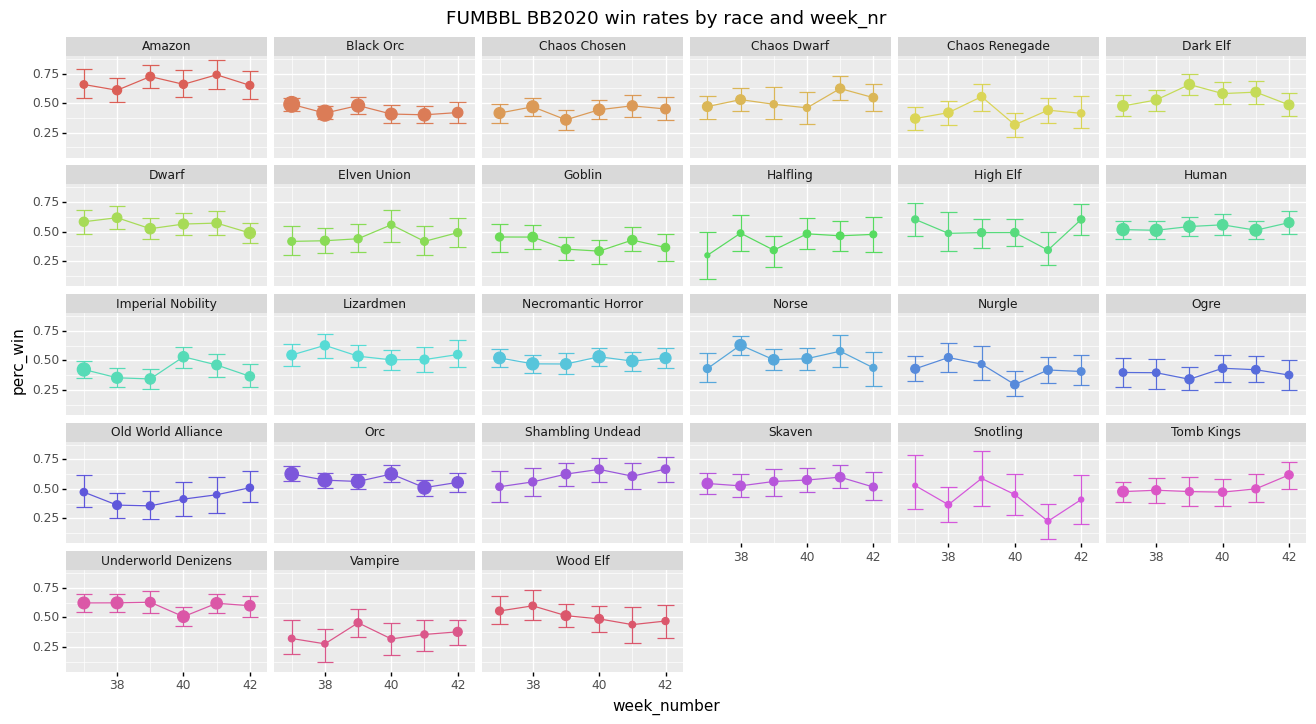

<ggplot: (8772466662397)>

In [29]:
# aggregate by year and week number

res = (df_wins.query('division_name == "Competitive"')
    .groupby(['week_number', 'year', 'ruleset', 'race_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res

res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

(p9.ggplot(data = res.query('year > 2020 & week_number > 36 & week_number < 43'), 
    mapping = p9.aes(x = 'week_number', y = 'perc_win', group = 'factor(race_name)', color = 'factor(race_name)'))
    + p9.geom_point(p9.aes(size = 'n_games')) 
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_line()
    + p9.scale_size_area() 
    + p9.facet_wrap('race_name')
    + p9.ggtitle("FUMBBL BB2020 win rates by race and week_nr")
    + p9.theme(figure_size=(16, 8)) 
    + p9.theme(legend_position='none'))

# Concluding remarks






In [30]:
#df_wins.query('week_number == 4') # DOES NOT WORK week_number has UINT32 dtype which is not supported by query ??? wtf
#df_wins.loc[(df_wins['week_number'] == 4) & (df_wins['ruleset'] == 2228)]

(df_wins.loc[(df_wins['ruleset'] == 2228) & (df_wins['roster_id'] == 4956)])
    #.groupby('roster_id')
    #.count()).sort_values('roster_id', ascending = False)

,match_id,match_date,team_id,wins,division_id,division_name,league,ruleset,roster_id,race_name,games_played,roster_name,week_number,year,ruleset_name
190,4334266,2021-10-09,1.04572e+06,0.5,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
475,4333981,2021-10-08,1.04798e+06,0.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
752,4333704,2021-10-07,1.04437e+06,1.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
754,4333702,2021-10-07,1.04763e+06,0.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
772,4333684,2021-10-07,1.04597e+06,0.0,5,NAF,9298,2228,4956,Black Orc,3,4956_Black Orc,40,2021.0,mixed
1257,4333199,2021-10-06,1.04649e+06,1.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
1362,4333094,2021-10-05,1.04543e+06,0.5,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
3515,4330941,2021-09-27,1.04733e+06,0.5,5,NAF,9298,2228,4956,Black Orc,1,4956_Black Orc,39,2021.0,mixed
118668,4338737,2021-10-26,1.04649e+06,0.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,43,2021.0,mixed
119269,4338136,2021-10-24,1.04798e+06,0.5,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,42,2021.0,mixed


In [31]:
# Check the league field
# aggregate by year and week number


res = (df_wins
    .groupby(['division_name', 'ruleset', 'league'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2

res.query('n_games > 2000')

,division_name,ruleset,league,n_games
0,Blackbox,1,0,36300.5
1,Ranked,1,0,21290.5
2,Regular_league,6,0,13194.5
3,Competitive,4,0,9457.0
4,Secret League,303,10263,5257.0
5,NAF,2228,9298,3437.5
